In [1]:
import json, sys, re, os
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import copy
import numpy as np

In [2]:
single_cnt = 3151
multiple_cnt = 751
models = [
    "baichuan-13b-chat",
    "chinese-alpaca-2-13b",
    "GPT-3.5-turbo",     
    "llama-2-13b-chat",  
    "qwen_chat_7b",
    "chatglm2-6b",        
    "chinese-llama-2-13b",   
    "internlm_chat_7b",  
    "llama-2-70b-int4",
    "llama-2-7b-chat"
]

models_abbr = [
    "Baichuan-13B-Chat",
    "Chinese-Alpaca-2-13B",
    "ChatGPT",     
    "LLaMA-2-13B",  
    "Qwen-7B-Chat",
    "ChatGLM2-6B",        
    "Chinese-LLaMA-2-13B",   
    "InternLM-7B",  
    "LLaMA-2-70B",
    "LLaMA-2-7B"
]

model_name_update = {model: abbr for model, abbr in zip(models, models_abbr)}

In [3]:
# with open("/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/network_results.csv", 'r', encoding='utf-8') as f:
#     data = json.load(f)
df = pd.read_csv("/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/network_results.csv")

In [5]:
df

,Unnamed: 0,model,dataset,qtype,sc,acc,chinese,cot,shot
0,0,qwen_chat_7b,3shot-sc-single,single,yes,0.573151,no,no,3shot
1,1,qwen_chat_7b,3shot-sc-single,single,no,0.586480,no,no,3shot
2,2,qwen_chat_7b,3shot-sc-multiple,multiple,yes,0.244000,no,no,3shot
3,3,qwen_chat_7b,3shot-sc-multiple,multiple,no,0.245333,no,no,3shot
4,4,qwen_chat_7b,3shot-sc+cot-single,single,yes,0.557283,no,yes,3shot
...,...,...,...,...,...,...,...,...,...
283,283,GPT-3.5-turbo,3shot-sc-multiple,multiple,no,0.505333,no,no,3shot
284,284,GPT-3.5-turbo,zh-3shot-sc-multiple,multiple,yes,0.407210,yes,no,3shot
285,285,GPT-3.5-turbo,zh-3shot-sc-multiple,multiple,no,0.400534,yes,no,3shot
286,286,GPT-3.5-turbo,zh-zeroshot-sc-multiple,multiple,yes,0.376502,yes,no,zeroshot


In [4]:
# 计算单选多选的平均分数

def cal_avg(s_a, m_a):
    return (s_a * single_cnt + m_a * multiple_cnt) / (single_cnt + multiple_cnt)

def get_abbr(sc, zh, cot, shot):
    abbr = shot + '_' + ('zh' if zh else 'en')
    if sc:
        abbr += '_sc'
    if cot:
        abbr += '_cot'
    return abbr

def get_all_stats(df):
    # 需要得到所有模型在所有场景下的平均分数
    settings = [
        get_abbr(sc, zh, cot, shot) for sc in [True, False] for zh in [True, False] for cot in [True, False] for shot in ['zeroshot', '3shot']
    ]
    dt = {
        setting:{
            model: dict() for model in models
        } for setting in settings
    }

    for ridx, row in df.iterrows():
        abbr = get_abbr(row['sc']=='yes', row['chinese']=='yes', row['cot']=='yes', row['shot'])
        dt[abbr][row['model']][row['qtype']] = row['acc']

    for setting, models_result in dt.items():
        for model, result in models_result.items():
            try:
                avg = cal_avg(result['single'], result['multiple'])
                result['avg'] = avg
            except:
                # print(setting, model)
                continue

    return dt

result_dt = get_all_stats(df)

In [5]:
def gen_table_df(dt):
    dt = copy.deepcopy(dt)
    for setting, models_result in dt.items():
        for model, result in models_result.items():
            try:
                models_result[model] = result['avg']
            except:
                models_result[model] = 'NULL'
    df = pd.DataFrame(dt)
    return df

avg_df = gen_table_df(result_dt)

In [43]:
avg_df

,zeroshot_zh_sc_cot,3shot_zh_sc_cot,zeroshot_zh_sc,3shot_zh_sc,zeroshot_en_sc_cot,3shot_en_sc_cot,zeroshot_en_sc,3shot_en_sc,zeroshot_zh_cot,3shot_zh_cot,zeroshot_zh,3shot_zh,zeroshot_en_cot,3shot_en_cot,zeroshot_en,3shot_en
baichuan-13b-chat,0.497213,0.555969,0.159919,0.36086,0.370327,0.178377,0.204001,0.266818,0.438537,0.512649,0.15223,0.342922,0.28601,0.18248,0.182985,0.241444
chinese-alpaca-2-13b,0.441631,0.426786,0.331426,0.439886,0.497202,0.504681,0.37726,0.485709,0.441631,0.426786,0.331426,0.439886,0.497202,0.504681,0.37726,0.485709
GPT-3.5-turbo,0.675507,0.673969,0.586303,0.59657,0.720023,0.724883,0.66849,0.682598,0.647564,0.651917,0.584249,0.592466,0.695668,0.709246,0.666185,0.6826
llama-2-13b-chat,0.569506,0.505909,0.315818,0.389383,0.586699,0.610285,0.464931,0.530318,0.51593,0.480287,0.296846,0.395536,0.530818,0.567989,0.418029,0.533389
qwen_chat_7b,0.535198,0.477277,0.299149,0.46908,0.500829,0.497757,0.460057,0.509801,0.505979,0.468557,0.29633,0.50368,0.473398,0.483404,0.459288,0.520821
chatglm2-6b,0.42238,0.394745,0.337098,0.360409,0.365483,0.404716,0.246551,0.376275,0.421355,0.395257,0.33838,0.360409,0.366252,0.405485,0.247833,0.376019
chinese-llama-2-13b,0.387753,0.322438,0.22527,0.418324,0.377764,0.287581,0.293957,0.403938,0.387753,0.322438,0.22527,0.418324,0.377764,0.287581,0.293957,0.403938
internlm_chat_7b,0.383699,0.413184,0.416549,0.425787,0.439035,0.51363,0.386746,0.451879,0.383699,0.413184,0.416549,0.425787,0.439035,0.51363,0.386746,0.451879
llama-2-70b-int4,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
llama-2-7b-chat,0.556132,0.503592,0.30222,0.407565,0.495428,0.55157,0.40034,0.467762,0.500519,0.45618,0.297611,0.386292,0.453904,0.519528,0.3947,0.48237


In [44]:
avg_df.to_csv("/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/avg_result.csv")

In [6]:
excel_file = "/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/network_sheets.xlsx"

xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names
print(sheet_names)
dfs = {}
for sheetname in sheet_names:
    df = pd.read_excel(excel_file, sheet_name=sheetname)
    dfs[sheetname] = df

for key, value in dfs.items():
    value.set_index('Models', inplace=True)
for lang in ['en', 'zh']:
    dfs[f'{lang}-zeroshot'] = dfs[f'{lang}-zeroshot'].reindex(index=dfs[f'{lang}-3shot'].index)
for key, value in dfs.items():
    value.reset_index(inplace=True)

['en-zeroshot', 'en-3shot', 'zh-zeroshot', 'zh-3shot']


In [6]:
dfs['en-zeroshot']

,Models,Naiive,SC,COT,SC+COT
0,GPT-3.5-turbo,66.6,66.8,69.6,72.0
1,llama-2-13b-chat,41.8,46.5,53.1,58.7
2,llama-2-7b-chat,39.5,40.0,45.4,49.5
3,internlm_chat_7b,38.7,38.7,43.9,43.9
4,chinese-alpaca-2-13b,37.7,37.7,49.7,49.7
5,qwen_chat_7b,45.9,46.0,47.3,50.1
6,chatglm2-6b,24.8,24.7,36.6,36.5
7,chinese-llama-2-13b,29.4,29.4,37.8,37.8
8,baichuan-13b-chat,18.3,20.4,28.6,37.0


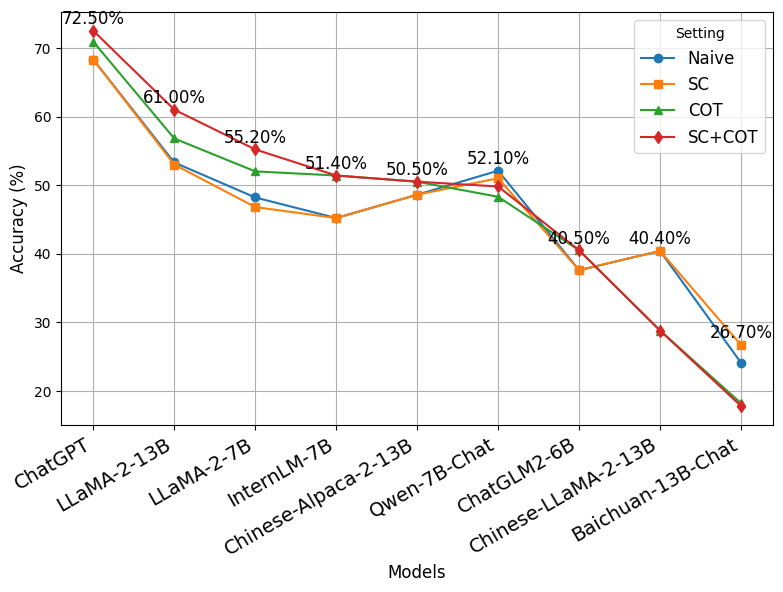

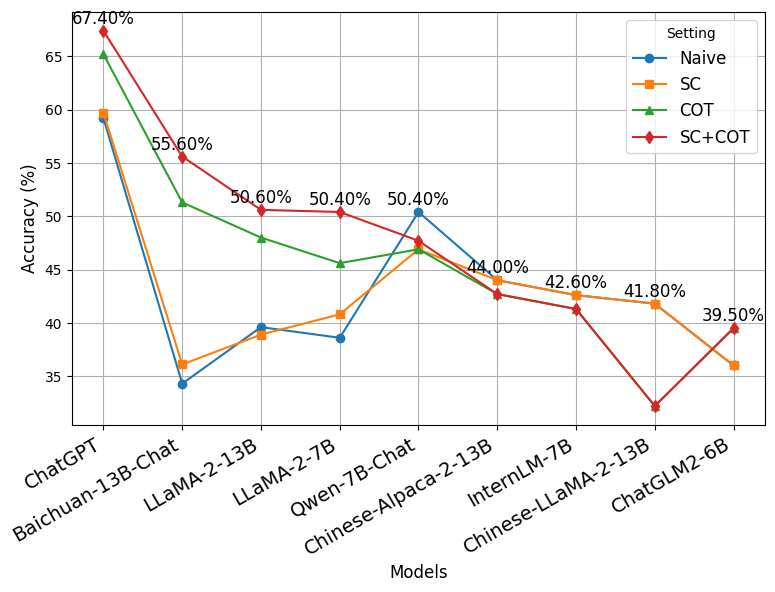

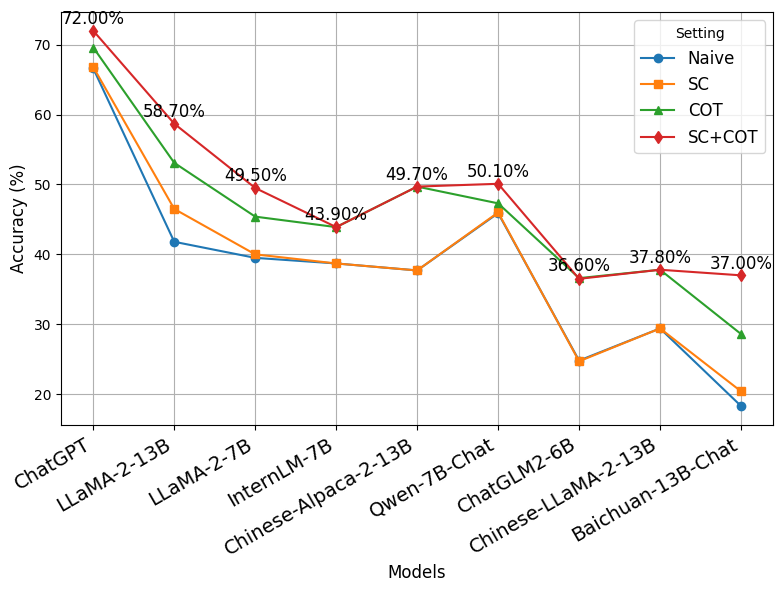

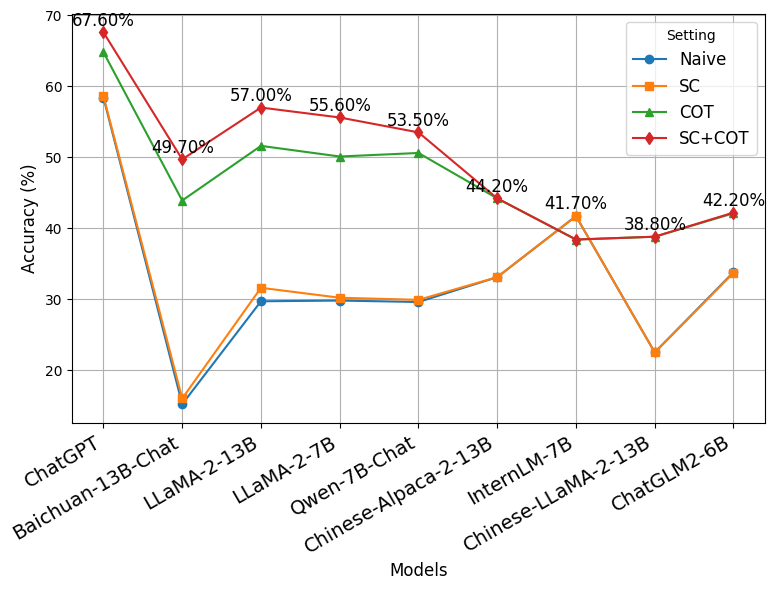

In [9]:
def plot_result(setting, df):
    # 设置图形的大小
    plt.figure(figsize=(8, 6))

    # 绘制折线图来展示结果
    plt.plot([model_name_update[model] for model in df['Models']], df['Naiive'], marker='o', label='Naive')
    plt.plot([model_name_update[model] for model in df['Models']], df['SC'], marker='s', label='SC')
    plt.plot([model_name_update[model] for model in df['Models']], df['COT'], marker='^', label='COT')
    plt.plot([model_name_update[model] for model in df['Models']], df['SC+COT'], marker='d', label='SC+COT')

    # 添加标题和标签
    # plt.title(f'{setting} Results')
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)

    # 添加图例
    plt.legend(title='Setting', fontsize=12)

    # 旋转x轴标签以避免重叠
    plt.xticks(rotation=30, ha='right',fontsize=14)

    # 显示网格线
    plt.grid()

    # 标注每个模型的最高点
    for model in df['Models']:
        max_accuracy = df[df['Models'] == model][['Naiive', 'SC', 'COT', 'SC+COT']].max(axis=1).values[0]
        max_index = df[df['Models'] == model][['Naiive', 'SC', 'COT', 'SC+COT']].idxmax(axis=1).values[0]
        plt.annotate(f'{max_accuracy:.2f}%', (model_name_update[model], max_accuracy), textcoords="offset points", xytext=(0,5), ha='center', fontsize=12)

    # 显示图表
    plt.tight_layout()
    plt.savefig(f"/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/plots/{setting}.pdf", format="pdf")

    plt.show()

plot_result('English Network Operation 3-shot', dfs['en-3shot'])
plot_result('Chinese Network Operation 3-shot', dfs['zh-3shot'])
plot_result('English Network Operation Zero-shot', dfs['en-zeroshot'])
plot_result('Chinese Network Operation Zero-shot', dfs['zh-zeroshot'])

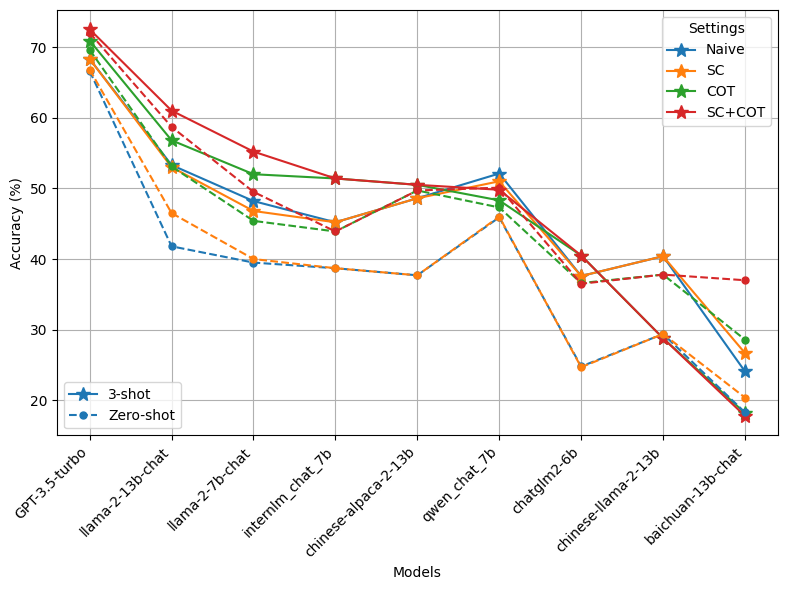

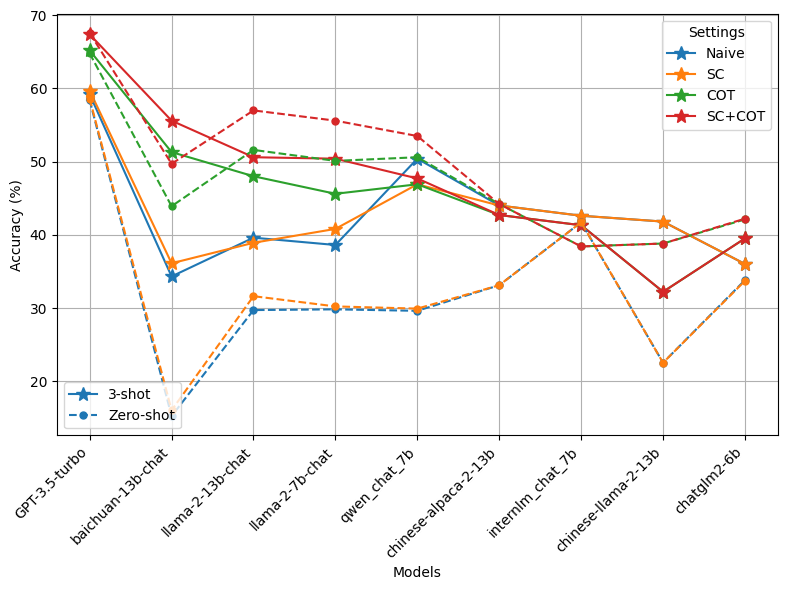

In [24]:
def plot_result2(setting, df_zeroshot, df_3shot):
    # 设置图形的大小
    plt.figure(figsize=(8, 6))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # 绘制折线图来展示结果
    # 绘制3shot数据的折线图
    plt.plot(df_3shot['Models'], df_3shot['Naiive'], marker='*', linestyle='-', label='Naive', color=colors[0], markersize=10)
    plt.plot(df_3shot['Models'], df_3shot['SC'], marker='*', linestyle='-', label='SC', color=colors[1], markersize=10)
    plt.plot(df_3shot['Models'], df_3shot['COT'], marker='*', linestyle='-', label='COT', color=colors[2], markersize=10)
    plt.plot(df_3shot['Models'], df_3shot['SC+COT'], marker='*', linestyle='-', label='SC+COT', color=colors[3], markersize=10)


    # 绘制zeroshot数据的折线图
    plt.plot(df_zeroshot['Models'], df_zeroshot['Naiive'], marker='.', linestyle='--', label='Naive', color=colors[0], markersize=10)
    plt.plot(df_zeroshot['Models'], df_zeroshot['SC'], marker='.', linestyle='--', label='SC', color=colors[1], markersize=10)
    plt.plot(df_zeroshot['Models'], df_zeroshot['COT'], marker='.', linestyle='--', label='COT', color=colors[2], markersize=10)
    plt.plot(df_zeroshot['Models'], df_zeroshot['SC+COT'], marker='.', linestyle='--', label='SC+COT', color=colors[3], markersize=10)


    # 添加标题和标签
    # plt.title(f'{setting} Results')
    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')

    # 添加图例
    lines = plt.gca().get_lines()
    line_3shot=[0,1,2,3]
    line_zeroshot = [4,5,6,7]
    legend1 = plt.legend([lines[i] for i in line_3shot], [lines[i].get_label() for i in line_3shot], loc=1, title='Settings')
    legend2 = plt.legend([lines[i] for i in [0,4]], ['3-shot', 'Zero-shot'], loc=3)
    plt.gca().add_artist(legend1)
    # plt.gca().add_artist(legend2)

    # 旋转x轴标签以避免重叠
    plt.xticks(rotation=45, ha='right')

    # 显示网格线
    plt.grid()

    # # 标注每个模型的最高点
    # for model in df_3shot['Models']:
    #     max_accuracy = df_3shot[df_3shot['Models'] == model][['Naiive', 'SC', 'COT', 'SC+COT']].max(axis=1).values[0]
    #     max_index = df_3shot[df_3shot['Models'] == model][['Naiive', 'SC', 'COT', 'SC+COT']].idxmax(axis=1).values[0]
    #     plt.annotate(f'{max_accuracy:.2f}%', (model, max_accuracy), textcoords="offset points", xytext=(0, 10), ha='center')

    # for model in df_zeroshot['Models']:
    #     max_accuracy = df_zeroshot[df_zeroshot['Models'] == model][['Naiive', 'SC', 'COT', 'SC+COT']].max(axis=1).values[0]
    #     max_index = df_zeroshot[df_zeroshot['Models'] == model][['Naiive', 'SC', 'COT', 'SC+COT']].idxmax(axis=1).values[0]
    #     plt.annotate(f'{max_accuracy:.2f}%', (model, max_accuracy), textcoords="offset points", xytext=(0, -20), ha='center')


    # 显示图表
    plt.tight_layout()
    plt.savefig(f"/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/plots/{setting}.pdf", format="pdf")

    plt.show()

plot_result2('English Network Operation', dfs['en-zeroshot'], dfs['en-3shot'])
plot_result2('Chinese Network Operation', dfs['zh-zeroshot'], dfs['zh-3shot'])

3-shot Naiive


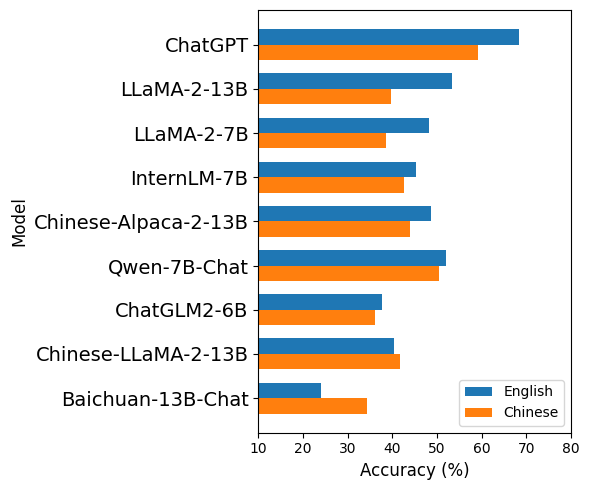

In [15]:

# 画点柱状图对比中英文
def plot_bar_en_zh(df_zh, df_en, title, setting='Naiive', xlim=[10,80]):
    # 首先需要整理
    # 对齐index
    df_zh = copy.deepcopy(df_zh)
    df_en = copy.deepcopy(df_en)
    df_en.set_index('Models', inplace=True)
    df_zh.set_index('Models', inplace=True)
    df_zh = df_zh.reindex(index=df_en.index)
    df_zh.reset_index(inplace=True)
    df_en.reset_index(inplace=True)

    print(title, setting)

    # 创建图表
    # 设置柱子的宽度
    bar_width = 0.35

    # 设置x轴的位置
    x = range(len([model_name_update[model] for model in df_zh['Models']]))

    # 创建图表
    plt.figure(figsize=(6, 5))

    # 自定义颜色
    colors = ['#1f77b4', '#ff7f0e']

    # 绘制英文准确率的柱子
    plt.barh([i - bar_width/2 for i in x], df_en[setting], bar_width, label='English', color=colors[0])

    # 绘制中文准确率的柱子
    plt.barh([i + bar_width/2 for i in x], df_zh[setting], bar_width, label='Chinese', color=colors[1])

    

    # 翻转
    plt.gca().invert_yaxis()

    # 设置y轴标签
    plt.yticks(x, [model_name_update[model] for model in df_zh['Models']], fontsize=14)

    # 设置x轴范围
    plt.xlim(xlim)

    # 设置图表标题和标签
    plt.xlabel('Accuracy (%)', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.legend()

    plt.tight_layout()

    plt.savefig(f"/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/plots/en_zh_comp_{title}_{setting}.pdf", format="pdf")

    # 显示图表
    plt.show()
    

plot_bar_en_zh(dfs['zh-3shot'], dfs['en-3shot'], '3-shot')
plot_bar_en_zh(dfs['zh-3shot'], dfs['en-3shot'], '3-shot', setting='SC+COT')
plot_bar_en_zh(dfs['zh-zeroshot'], dfs['en-zeroshot'], 'Zero-shot', xlim=[10,70])
plot_bar_en_zh(dfs['zh-zeroshot'], dfs['en-zeroshot'], 'Zero-shot', setting='SC+COT', xlim=[20,80])